In [1]:
import mlrose_hiive as mlrose
import numpy as np
import math
import logging
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, LearningCurveDisplay, ShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
np.random.seed(88)
# switch off the chatter
logging.basicConfig(level=logging.WARNING)

In [2]:
RHC_COLOR = 'tab:blue'
SA_COLOR = 'tab:orange'
GA_COLOR = 'tab:green'
MIMIC_COLOR = 'tab:red'

## Discrete Optimization Problem  Functions

In [3]:
'''
Randomized Hill Climbing Algorithm
https://mlrose.readthedocs.io/en/stable/source/algorithms.html#mlrose.algorithms.random_hill_climb
Params: max_attempts=50, restarts=10
'''
def rhc(problem, restarts=10):
    t0 = time.time()
    _, best_fitness, curve = mlrose.random_hill_climb(problem=problem, max_attempts=50, restarts=restarts, curve=True)
    t1 = time.time()
    return best_fitness, t1-t0, curve

'''
Simulated Annealing Algorithm
https://mlrose.readthedocs.io/en/stable/source/algorithms.html#mlrose.algorithms.simulated_annealing
Params: max_attempts=50
'''
def sa(problem, schedule=mlrose.GeomDecay()):
    t0 = time.time()
    _, best_fitness, curve = mlrose.simulated_annealing(problem=problem, curve=True, max_attempts=25,
                                                        schedule=schedule)
    t1 = time.time()
    return best_fitness, t1-t0, curve

'''
Genetic Algorithm
https://mlrose.readthedocs.io/en/stable/source/algorithms.html#mlrose.algorithms.genetic_alg
Params: max_attempts=50
'''

def ga(problem):
    t0 = time.time()
    _, best_fitness, curve = mlrose.genetic_alg(problem=problem, max_attempts=50, curve=True)
    t1 = time.time()
    return best_fitness, t1-t0, curve

'''
MIMIC Algorithm
https://mlrose.readthedocs.io/en/stable/source/algorithms.html#mlrose.algorithms.mimic
Params: max_attempts=50
'''
def mimic(problem):
    t0 = time.time()
    _, best_fitness, curve = mlrose.mimic(problem=problem, max_attempts=50, curve=True)
    t1 = time.time()
    return best_fitness, t1-t0, curve

'''
Generates data for best fitness score vs. problem size, time vs. problem size
    inputs : range of integers used to define problem size
    algorithm : optimization algorithm to run - rhc, sa, ga, mimic
    problem : optimization problem to solve - 'OneMax', 'FourPeaks, 'Kcolor'
'''    
def fitness_time_trial(inputs, algorithm, problem):
    fitnesses = []
    times = []
    if problem == 'OneMax':
        fitness = mlrose.OneMax()
        for x in inputs:
            opt_problem = mlrose.DiscreteOpt(length=x, fitness_fn=fitness, maximize=True)
            opt_problem.set_mimic_fast_mode(True)
            trial_fitness, trial_time, _ = algorithm(opt_problem)
            fitnesses.append(trial_fitness / x)
            times.append(trial_time)
    elif problem == 'FlipFlop':
        fitness = mlrose.FlipFlop()
        for x in inputs:
            opt_problem = mlrose.FlipFlopGenerator.generate(size=x, seed=8)
            opt_problem.set_mimic_fast_mode(True)
            trial_fitness, trial_time, _ = algorithm(opt_problem)
            fitnesses.append(trial_fitness)
            times.append(trial_time)
    elif problem == 'FourPeaks':
        fitness = mlrose.FourPeaks(t_pct=0.1)
        for x in inputs:
            opt_problem = mlrose.DiscreteOpt(length=x, fitness_fn=fitness, maximize=True)
            opt_problem.set_mimic_fast_mode(True)
            trial_fitness, trial_time, _ = algorithm(opt_problem)
            fitnesses.append(trial_fitness)
            times.append(trial_time)
    return np.asarray(fitnesses), np.asarray(times)

'''
Generate and save plot of results for a problem
'''
# generate graphs
def fitness_time_experiment(problem, fname, inputs, runs):
    t0 = time.time()
    # Problem sizes
    fig, axs = plt.subplots(2, figsize=(12, 12))
    algorithms = [rhc, sa, ga, mimic]
    colors = [RHC_COLOR, SA_COLOR, GA_COLOR, MIMIC_COLOR]
    labels = ['Random Hill Climbing', 'Simulated Annealing', 'Genetic Algorithm', 'MIMIC']
    for i in range(len(colors)):
        algo = algorithms[i]
        color = colors[i]
        fitness_arr = []
        time_arr = []
        for j in range(runs):
            fit, t = fitness_time_trial(inputs, algo, problem)
            fitness_arr.append(fit)
            time_arr.append(t)
        fitness = np.asarray(fitness_arr).mean(axis=0)
        times = np.asarray(time_arr).mean(axis=0)
        axs[0].plot(inputs, fitness, label=labels[i], color=color)
        axs[1].plot(inputs, times, label=labels[i], color=color)
    axs[0].set_xlabel('Problem Size')
    axs[1].set_xlabel('Problem Size')
    if problem == 'OneMax':
        axs[0].set_ylabel('Best Fitness Score / Max Fitness Score')
    else:
        axs[0].set_ylabel('Best Fitness Score')
    axs[1].set_ylabel('Time [Seconds]')
    axs[0].legend(labels, loc='lower left')
    axs[1].legend(labels, loc='upper left')
    axs[0].set_title('Fitness Score vs. Problem Size')
    axs[1].set_title('Time vs. Problem Size')
    plt.savefig(fname=fname)
    return time.time() - t0

def four_peaks_optimization():
    fitness = mlrose.FourPeaks(t_pct=0.10)
    problem = mlrose.DiscreteOpt(length=100, fitness=fitness, maximize=True)
    problem.set_mimic_fast_mode(True)
    # Exploring Simulated Annealing params
    # Decay Schedules
    #

## Neural Network Optimization

In [12]:
data = load_iris()
scaler = MinMaxScaler()
one_hot = OneHotEncoder()

X = np.asarray(scaler.fit_transform(data.data))
Y = np.asarray(one_hot.fit_transform(data.target.reshape(-1, 1)).todense())

# Split data
train_x, test_x, train_y, test_y = train_test_split(X, Y, random_state=8, test_size=0.2)

In [5]:
# Models
backprop_NN = MLPClassifier(alpha=1e-4, max_iter=1000, hidden_layer_sizes=(50, 50), 
                         random_state=8, learning_rate='constant', early_stopping=True)

rhc_NN = mlrose.NeuralNetwork(algorithm='random_hill_climb', max_iters=1000, early_stopping=True,
                              restarts=10, random_state=8, curve=True, hidden_nodes=(50, 50))

sa_NN = mlrose.NeuralNetwork(algorithm='simulated_annealing', max_iters=1000, early_stopping=True, random_state=8,
                             curve=True, hidden_nodes=(50, 50))

ga_NN = mlrose.NeuralNetwork(algorithm='genetic_alg', max_iters=1000, early_stopping=True, random_state=8,
                             curve=True, hidden_nodes=(50, 50))

In [6]:
def NN_accuracy_plots():
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(18, 8), sharey=True)
    common_params = {
        "X": np.asarray(X),
        "y": np.asarray(Y),
        "train_sizes": np.linspace(0.1, 1.0, 5),
        "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
        "score_type": "both",
        "n_jobs": 4,
        "line_kw": {"marker": "o"},
        "std_display_style": "fill_between",
        "score_name": "Accuracy",
    }

    titles = ['Backpropagation', 'Randomized Hill Climbing',
              'Simulated Annealing', 'Genetic Algorithm']
    for ax_idx, estimator in enumerate([backprop_NN, rhc_NN, sa_NN, ga_NN]):
        LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
        handles, label = ax[ax_idx].get_legend_handles_labels()
        ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
        ax[ax_idx].set_title(f"Learning Curve for {titles[ax_idx]}")
    plt.savefig('NN_Learning_Curves')

In [7]:
def NN_loss_plots():
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 8), sharey=False)
    titles = ['Backpropagation', 'Randomized Hill Climbing',
              'Simulated Annealing', 'Genetic Algorithm']
    for ax_idx, estimator in enumerate([backprop_NN, rhc_NN, sa_NN, ga_NN]):
        estimator.fit(train_x, train_y)
        if titles[ax_idx] == 'Backpropagation':
            ax[ax_idx].plot(estimator.loss_curve_)
            ax[ax_idx].set_ylabel('Loss')
            ax[ax_idx].set_title(f"Loss Curve for {titles[ax_idx]}")
        else:
            ax[ax_idx].plot(estimator.fitness_curve)
            ax[ax_idx].set_ylabel('Fitness')
            ax[ax_idx].set_title(f"Fitness Curve for {titles[ax_idx]}")
        ax[ax_idx].set_xlabel('Iterations')
    plt.savefig('NN_Loss_Curves')

In [8]:
def mlp_tuning():
    default_parameters = {
    'seed': 8,
    'max_attempts': 5000,
    'iteration_list': 2 ** np.arange(13),
    'n_jobs':1,
    'cv':5,
    }
    
    default_grid_search_parameters = {
    'max_iters': [5000],
    'learning_rate_init': [0.1, 0.2, 0.4, 0.8],
    'hidden_layer_sizes': [(4), (10), (4, 4), (50, 50), (4, 4, 4)],
    'activation': [mlrose.neural.activation.relu, mlrose.neural.activation.sigmoid, mlrose.neural.activation.tanh]
    }
    
    skmlp_grid_search_parameters = {
    **default_grid_search_parameters,
    'max_iters': [5000],
    'learning_rate_init': [0.0001],
    
    }
    skmlp_default_parameters = {
    **default_parameters,
    'early_stopping':True,
    'tol':1e-05,
    'alpha':0.001,
    'solver':'lbfgs',
    }
        
    
    mlp_runner = mlrose.runners.SKMLPRunner(x_train=train_x, y_train=train_y,
                                           x_test = test_x, y_test=test_y,
                                           experiment_name='MLP_Tune',
                                            grid_search_parameters=default_grid_search_parameters,
                                            override_ctrl_c_handler=False,
                                            **skmlp_default_parameters)
    run_stats_df, curves_df, cv_results_df, cx_sr = mlp_runner.run()
    return run_stats_df, curves_df, cv_results_df, cx_sr

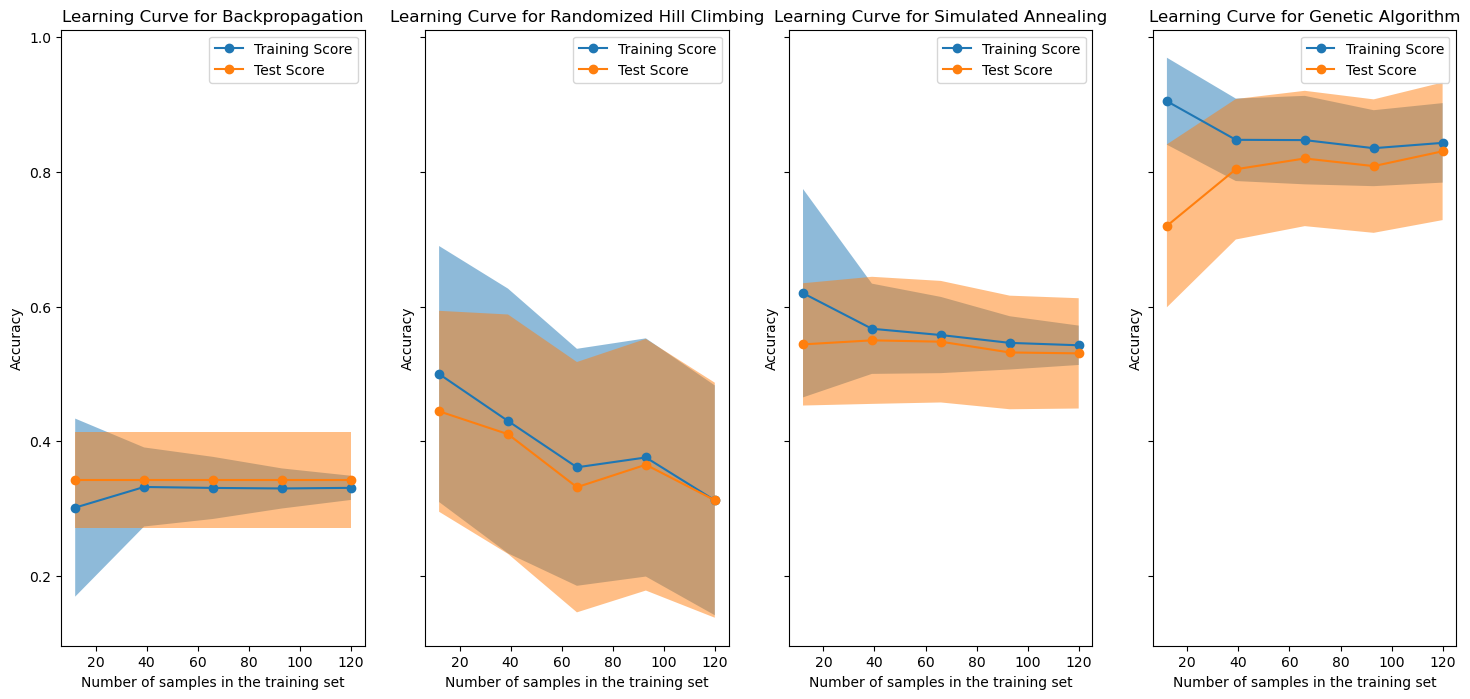

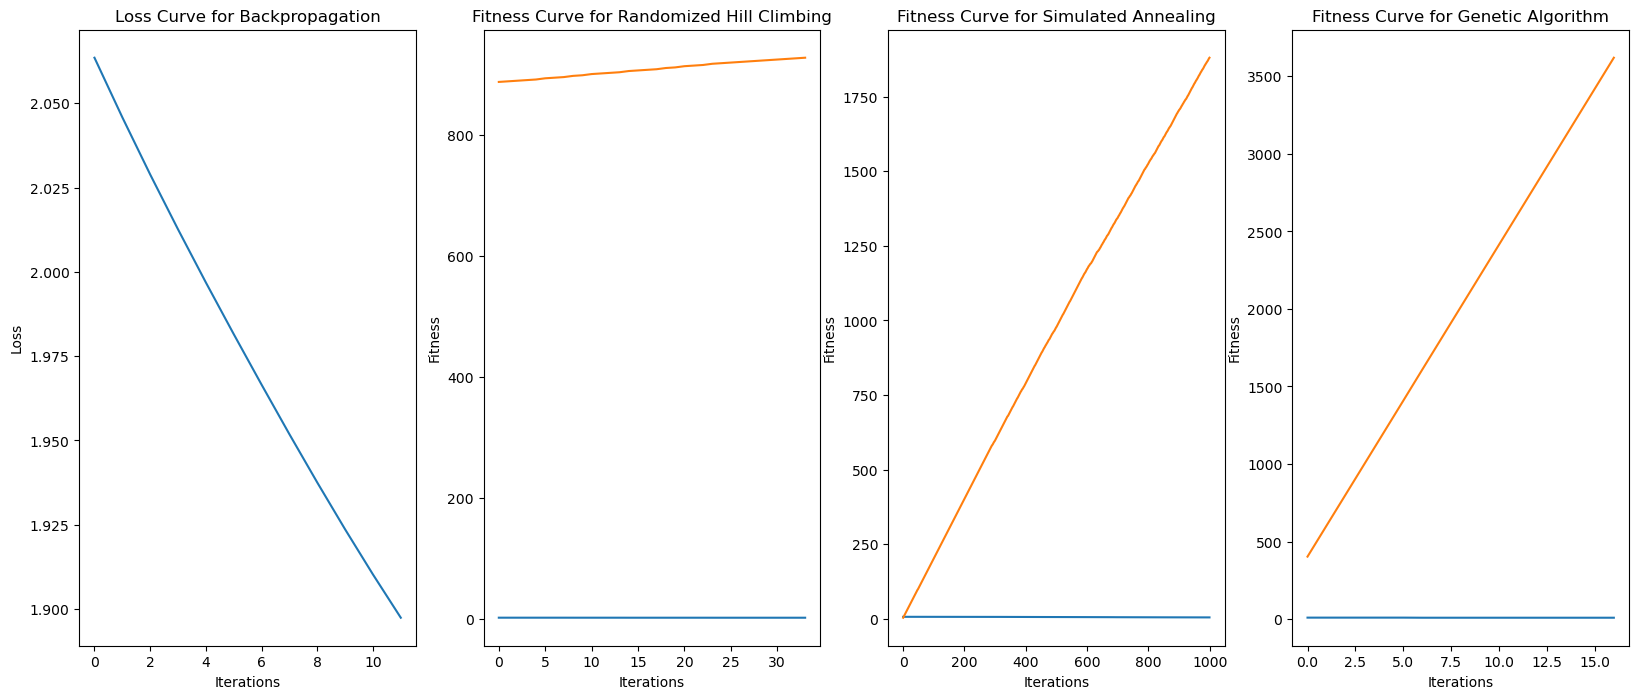

In [10]:
if __name__ == '__main__':
    fitness_time_experiment('OneMax', 'OneMaxResults', np.arange(1, 201), 10)
    fitness_time_experiment('FlipFlop', 'FlipFlopResults', np.arange(2,201), 10)
    fitness_time_experiment('FourPeaks', 'FourPeaksResults', np.arange(2, 201), 10)
    #mlp_tuning()
    NN_accuracy_plots()
    NN_loss_plots()